<a href="https://colab.research.google.com/github/apthagowda97/computer_vision_poc/blob/master/classification/notebook/scratch_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [91]:
import os
import time
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import accuracy_score,roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms

In [92]:
SEED = 42
BATCH_SIZE = 32
SIZE = [256,256]
LR = 0.0001
WEIGHT_DECAY = 0
EPOCHS = 12
TTA = 4

In [93]:
def seed_everything(SEED):
    np.random.seed(SEED);
    torch.manual_seed(SEED);
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True; 
    torch.backends.cudnn.benchmark = False

In [94]:
seed_everything(SEED) 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("CURRENT DEVICE: {0}".format(device))

CURRENT DEVICE: cpu


In [95]:
%%shell

wget https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz
tar -xzf flower_photos.tgz

--2020-08-28 18:24:46--  https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.204.128, 172.217.203.128, 173.194.216.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228813984 (218M) [application/x-compressed-tar]
Saving to: ‘flower_photos.tgz.2’

flower_photos.tgz.2 100%[===================>] 218.21M   139MB/s    in 1.6s    

2020-08-28 18:24:48 (139 MB/s) - ‘flower_photos.tgz.2’ saved [228813984/228813984]



In [96]:
image_name = [];flower_name = []
for dir_name in os.listdir('flower_photos'):
  if os.path.isdir(os.path.join('flower_photos',dir_name)):
    names = os.listdir(os.path.join('flower_photos',dir_name))
    image_name.extend(names)
    flower_name.extend([dir_name]*len(names))

In [97]:
le = LabelEncoder()
flower_df = pd.DataFrame(data={'flower_name':flower_name,'image_name':image_name})
flower_df['image_path'] = flower_df['flower_name']+'/'+flower_df['image_name']
flower_df['target'] = le.fit_transform(flower_df['flower_name'])
print("Target : {}".format(le.classes_))

Target : ['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


In [98]:
flower_df = flower_df.sample(frac=1,random_state=42).reset_index(drop=True)
flower_df.head()

,flower_name,image_name,image_path,target
0,dandelion,2542908888_25a1c78ff0.jpg,dandelion/2542908888_25a1c78ff0.jpg,1
1,roses,2059172936_032ffc12aa.jpg,roses/2059172936_032ffc12aa.jpg,2
2,sunflowers,3865206264_5d81584bba.jpg,sunflowers/3865206264_5d81584bba.jpg,3
3,daisy,3468498624_d082f99e98.jpg,daisy/3468498624_d082f99e98.jpg,0
4,daisy,144603918_b9de002f60_m.jpg,daisy/144603918_b9de002f60_m.jpg,0


In [99]:
train_and_valid,test = train_test_split(flower_df,test_size=0.1,random_state=SEED)
train,valid = train_test_split(train_valid,test_size=0.2,random_state=SEED)
print("The size of train: {0}, valid: {1} and test: {2}".format(len(train),len(valid),len(test)))

The size of train: 2642, valid: 661 and test: 367


In [100]:
transform = {
    'train' : transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [103]:
class FLOWERS(Dataset):
    def __init__(self,df,transform=None,train=True):
        self.df = df
        self.transform = transform
        self.train = train
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        if self.train==True:
            image_path = self.df.iloc[idx]['image_path']
            image = plt.imread(os.path.join('flower_photos',image_path))
            label = self.df.iloc[idx]['target']
            if self.transform is not None:
                image = self.transform(image=image)
            return {'image': image,'label': label }
        else:
            image_path = self.df.iloc[idx]['image_path']
            image = plt.imread(os.path.join('flower_photos',image_path))
            if self.transform is not None:
                image = self.transform(image=image)
            return {'image':image}

In [ ]:
def plot_images(inp, title=None):
    """Imshow for Tensor."""
    plt.figure(figsize=(10,10))
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.axis('off')
    if title is not None:
        plt.title(title)


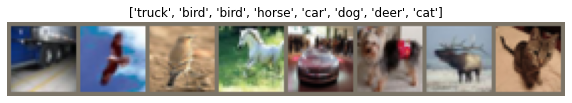

In [ ]:
images, labels = next(iter(trainloader))
out = torchvision.utils.make_grid(images)
plot_images(out, title=[classes[i] for i in labels])

In [ ]:
class NET(nn.Module):
    def __init__(self):
        super(NET, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x